In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/optiver-trading-at-the-close/public_timeseries_testing_util.py
/kaggle/input/optiver-trading-at-the-close/train.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv
/kaggle/input/optiver-trading-at-the-close/optiver2023/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/optiver-trading-at-the-close/optiver2023/__init__.py


In [2]:
# Deps
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer


## Load the data

In [3]:
# Load and preprocess the data
train_df = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')
train_df.head()


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


## EDA

In [4]:
def print_df(df):
    # Print the shape of the DataFrame
    print("Shape of the DataFrame:", df.shape)
    # Print the columns of the DataFrame
    print("Columns in the DataFrame:", df.columns)


print_df(train_df)

Shape of the DataFrame: (5237980, 17)
Columns in the DataFrame: Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id'],
      dtype='object')


In [5]:
# Available Stocks count
len(train_df.stock_id.unique())

200

<Axes: >

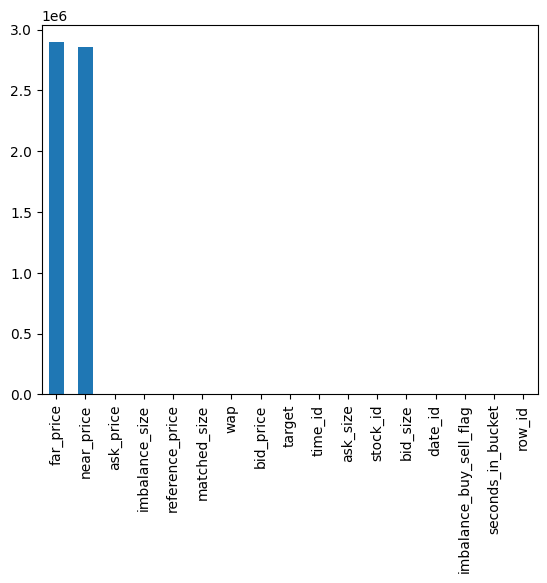

In [6]:
train_df.isna().sum().sort_values(ascending=False).plot(kind='bar')

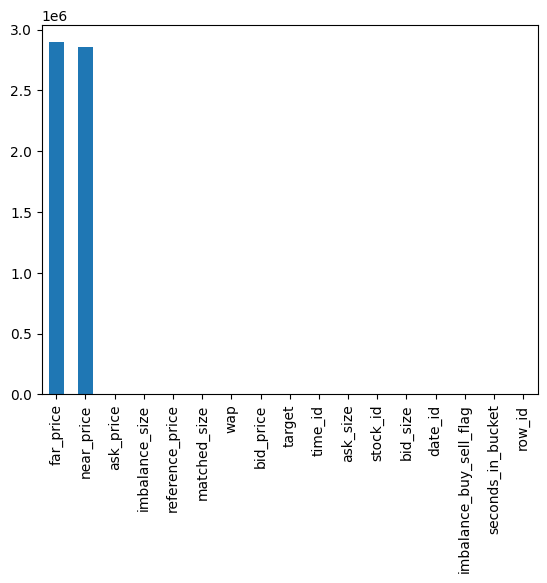

In [7]:
# Check the total null values of df
def check_null(df,return_null_cols=False, null_cols_count=2, ):
    df = df.copy()
    vals = df.isna().sum().sort_values(ascending=False).plot(kind='bar')
    if return_null_cols:
        return vals[:null_cols_count].index

null_cols = check_null(train_df)

In [8]:
null_cols

In [9]:
# Drip high null columsn
high_null_cols = train_df.isna().sum().sort_values(ascending=False)[:2].index

print(f"high null values: {high_null_cols}")

def drop_cols(df, cols):
    df = df.drop(cols, axis=1)
    return df

df = drop_cols(train_df, high_null_cols)
df = drop_cols(df, ['row_id'])

high null values: Index(['far_price', 'near_price'], dtype='object')


In [10]:
def imputer(df_processed):
    '''
    Function that receives a dataframe and returns the median value of each missing value in a column partitioned by stock_id,
    '''
    stock_list = list(df_processed['stock_id'].unique())

    imputer_columns = ['imbalance_size', 'reference_price', 'matched_size', 'bid_price', 'ask_price',
                       'wap', 'target', 'seconds_in_bucket', 'bid_size', 'ask_size']

    # Create a single SimpleImputer instance for each column
    imputers = {col: SimpleImputer(missing_values=np.nan, strategy='median') for col in imputer_columns}

    for stock in stock_list:
        stock_df = df_processed.loc[df_processed['stock_id'] == stock]

        # Apply imputation to each column
        for col, imputer in imputers.items():
            stock_df.loc[:,col] = imputer.fit_transform(stock_df[col].values.reshape(-1,1))

        # Update the original DataFrame with imputed values
        df_processed.loc[df_processed['stock_id'] == stock, imputer_columns] = stock_df[imputer_columns].values

    return df_processed, imputers

df_processed, imputers = imputer(df)

In [11]:
imputers

{'imbalance_size': SimpleImputer(strategy='median'),
 'reference_price': SimpleImputer(strategy='median'),
 'matched_size': SimpleImputer(strategy='median'),
 'bid_price': SimpleImputer(strategy='median'),
 'ask_price': SimpleImputer(strategy='median'),
 'wap': SimpleImputer(strategy='median'),
 'target': SimpleImputer(strategy='median'),
 'seconds_in_bucket': SimpleImputer(strategy='median'),
 'bid_size': SimpleImputer(strategy='median'),
 'ask_size': SimpleImputer(strategy='median')}

In [12]:
def apply_imputer(df_processed, imputers):
    imputer_columns = ['imbalance_size', 'reference_price', 'matched_size', 'bid_price', 'ask_price',
                       'wap', 'seconds_in_bucket', 'bid_size', 'ask_size']

    for col in imputer_columns:
        df_processed[col] = imputers[col].transform(np.array(df_processed[col]).reshape(-1, 1))

    return df_processed

In [13]:
df_processed = apply_imputer(df_processed, imputers)

In [14]:
### Test dataset:
test_df = pd.read_csv("/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv")
test_df_targets = pd.read_csv("/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv")

sample_submission = pd.read_csv("/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv")
test_df


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id,currently_scored
0,0,478,0,3753451.43,-1,0.999875,11548975.43,NaN,NaN,0.999875,22940.00,1.000050,9177.60,1.000000,26290,478_0_0,False
1,1,478,0,985977.11,-1,1.000245,3850033.97,NaN,NaN,0.999940,1967.90,1.000601,19692.00,1.000000,26290,478_0_1,False
2,2,478,0,599128.74,1,1.000584,4359198.25,NaN,NaN,0.999918,4488.22,1.000636,34955.12,1.000000,26290,478_0_2,False
3,3,478,0,2872317.54,-1,0.999802,27129551.64,NaN,NaN,0.999705,16082.04,1.000189,10314.00,1.000000,26290,478_0_3,False
4,4,478,0,740059.14,-1,0.999886,8880890.78,NaN,NaN,0.999720,19012.35,1.000107,7245.60,1.000000,26290,478_0_4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32995,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,26454,480_540_195,False
32996,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,26454,480_540_196,False
32997,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,26454,480_540_197,False
32998,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,26454,480_540_198,False


## PreProcessing for X Train y Train

In [15]:
y = df_processed['target']
X = df_processed.drop(['target'], axis = 1)

In [16]:
X = X.drop(['time_id'], axis = 1)

In [17]:
# Use this same cols to test data
X_cols = X.columns

In [18]:
a = df_processed[(df_processed.date_id<385)]
y_train = a['target']
X_train = a.drop(['target','time_id'], axis = 1)

a = df_processed[(df_processed.date_id>=385)]
y_test = a['target']
X_test = a.drop(['target','time_id'], axis = 1)

## Building model

In [19]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Assuming df_processed is your training data DataFrame
# Replace 'your_target_column' with the actual column name in your dataset
#X = df_processed.drop('target', axis=1)
#y = df_processed['target']

# Split the data into training, validation, and test sets
#X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
#X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Define LightGBM parameters (you can adjust these as needed)
params = {
    "objective": "regression",
    "metric": "mae",
        "n_estimators": 1000,
        "num_leaves": 512,
        "subsample": 0.4,
        "colsample_bytree": 0.6,
        "learning_rate": 0.00865,
        'max_depth': 24,
        "n_jobs": 4,
        "verbosity": -1,
        "reg_alpha": 0.1,
        "reg_lambda": 3.25
}
callbacks = [lgb.early_stopping(100), lgb.log_evaluation(100)]

# Train the LightGBM model
num_round = 1000  # You can adjust the number of boosting rounds
bst = lgb.train(params, train_data, num_round, valid_sets=[valid_data], callbacks=callbacks)
#bst = lgb.cv(params, train_data, folds=None, nfold=5, stratified=False, shuffle=False, callbacks=callbacks)
## Make predictions on the test set
#test_predictions = bst.predict(X_test)

# Evaluate the model on the test set using MAE
# Note: Replace 'your_target_column' with the actual column name in your dataset
#mae = mean_absolute_error(y_test, test_predictions)
#print(f'Mean Absolute Error on the test set: {mae}')


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 6.01551
[200]	valid_0's l1: 5.9983
[300]	valid_0's l1: 5.99329
[400]	valid_0's l1: 5.9915
[500]	valid_0's l1: 5.99196
Early stopping, best iteration is:
[405]	valid_0's l1: 5.99137


## Evaluation

### Prediction on the real test data

In [20]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

In [21]:
counter = 0
for (test, revealed_targets, test_preds) in iter_test:
    test_preds['target'] = bst.predict(test[X_cols])
    env.predict(test_preds)
    counter += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
